## Feed forward NN

Training Progress:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1000/1000, Loss: 0.0000: 100%|██████████| 1000/1000 [03:52<00:00,  4.29it/s]


Test Loss: 1.2090956233787425e-05


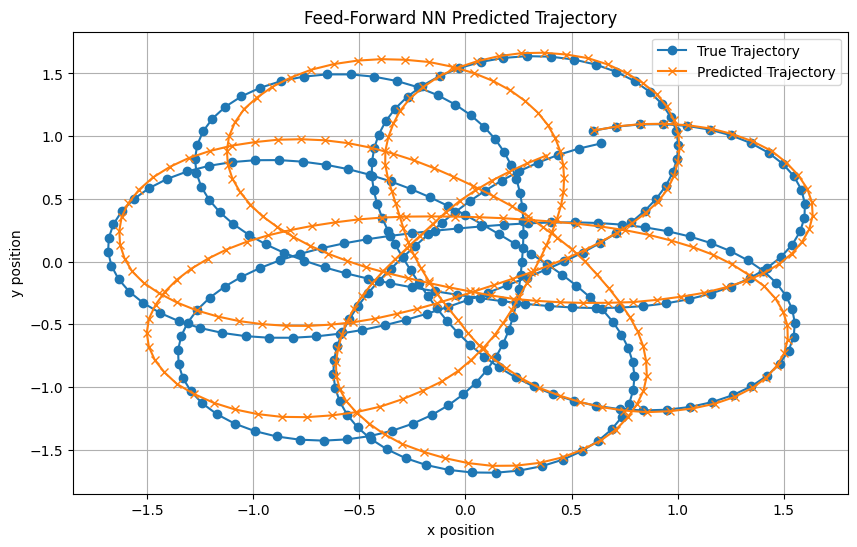

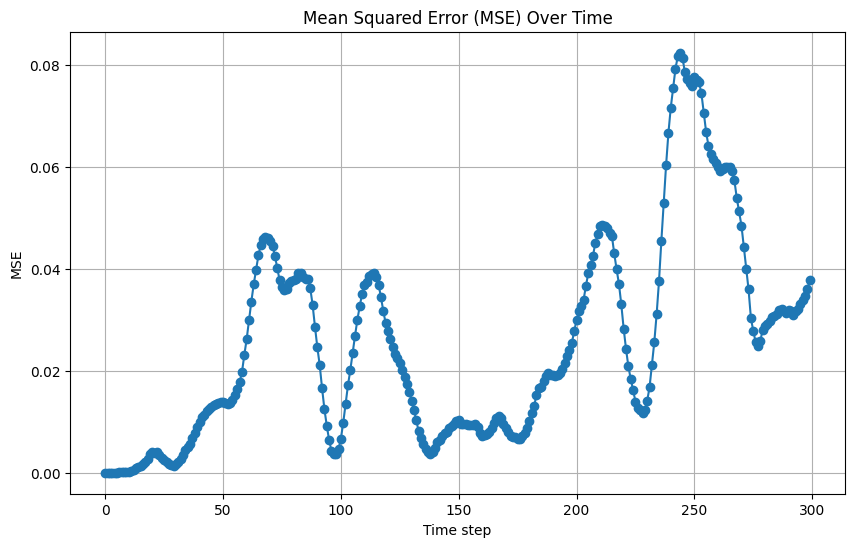

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import get_dataloaders
from src.network import FeedForwardNN, RecurrentNN
from train import train_model, evaluate_model
from plotting import extract_initial_state_and_true_positions, plot_predicted_trajectories

batch_size = 64
num_epochs = 1000
seq_length = 1  # Single step sequence

train_loader, test_loader = get_dataloaders(batch_size, "data_lorentz/train.txt", "data_lorentz/test.txt", seq_length=seq_length)

# Instantiate the model, define loss function and optimizer
model = FeedForwardNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, train_loader, criterion, optimizer, num_epochs)
evaluate_model(model, test_loader, criterion)

# Extract initial state and true positions for iterative prediction
initial_state, true_positions = extract_initial_state_and_true_positions(test_loader, steps=300)


# Plot predicted trajectories using the model iteratively
predicted_positions = plot_predicted_trajectories(model, initial_state, true_positions, 'Feed-Forward NN Predicted Trajectory')

# Calculate and plot mean squared error (MSE) as a function of time
# mse = np.mean((true_positions - np.array(predicted_positions)) ** 2, axis=1)
mse = np.mean((np.array(np.subtract(true_positions,predicted_positions))) ** 2, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(mse, marker='o')
plt.title('Mean Squared Error (MSE) Over Time')
plt.xlabel('Time step')
plt.ylabel('MSE')
plt.grid(True)
plt.show()


## Recurrent NN

Epoch 100/100, Loss: 0.0001: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Test Loss: 5.620470464679169e-05


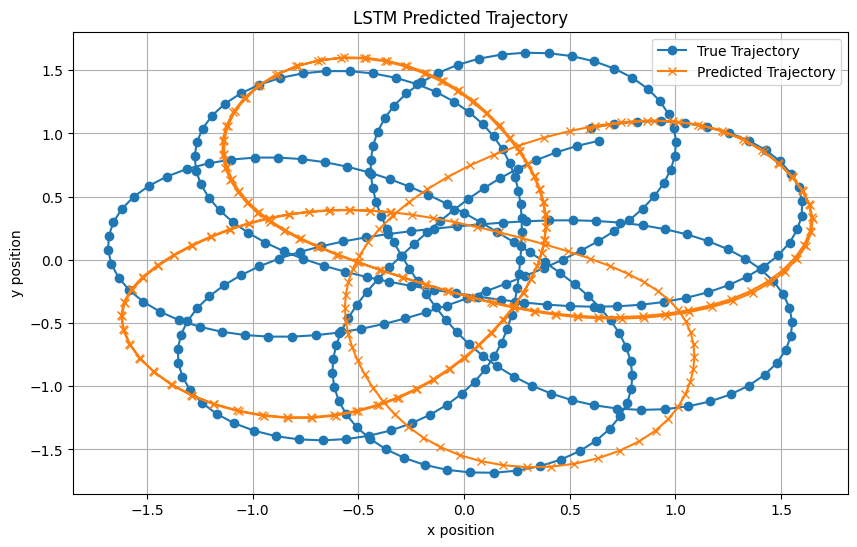

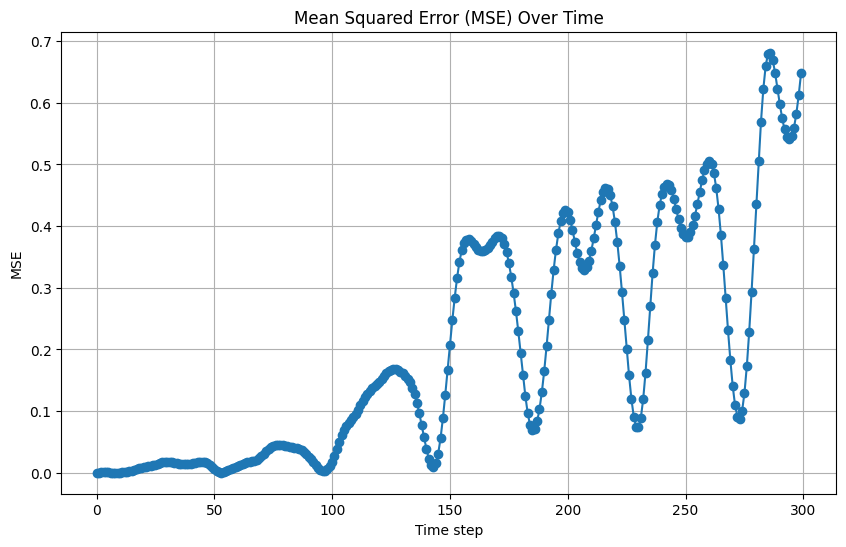

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import get_dataloaders_LSTM
from src.network import RecurrentNN
from train import train_model, evaluate_model
from tqdm.auto import tqdm
from plotting import extract_initial_state_and_true_positions_LSTM, plot_predicted_trajectories_LSTM

batch_size = 64
num_epochs = 100
seq_length = 1  # Single step sequence

# Get dataloaders
train_loader, test_loader = get_dataloaders_LSTM(batch_size, "data_lorentz/train.txt", "data_lorentz/test.txt", seq_length=seq_length)

# Instantiate the LSTM model, define loss function and optimizer
rnn_model = RecurrentNN(input_size=4, hidden_size=64, output_size=4, num_layers=4)
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Train the LSTM model
train_model(rnn_model, train_loader, criterion, optimizer, num_epochs=num_epochs)
# Evaluate the LSTM model
evaluate_model(rnn_model, test_loader, criterion)

# Extract initial state and true positions for iterative prediction
initial_state, true_positions = extract_initial_state_and_true_positions_LSTM(test_loader, steps=300)

# Plot predicted trajectories using the model iteratively
predicted_positions = plot_predicted_trajectories_LSTM(rnn_model, initial_state, true_positions, 'LSTM Predicted Trajectory', steps=300)

# Calculate and plot mean squared error (MSE) as a function of time
# mse = np.mean((true_positions - predicted_positions) ** 2, axis=1)
mse = np.mean((np.array(np.subtract(true_positions,predicted_positions))) ** 2, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(mse, marker='o')
plt.title('Mean Squared Error (MSE) Over Time')
plt.xlabel('Time step')
plt.ylabel('MSE')
plt.grid(True)
plt.show()


## Physics informed NN

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from src.dataset import get_dataloaders
from src.network import FeedForwardNN
from train import train_model, evaluate_model
from tqdm.auto import tqdm
import torch.autograd as ag

# batch_size = 64
epochs = 100
n_data = 300

## ------------------ set up models-------------------------- ##
# set network size
n_in = 4 # 2 channels position and 2 channels velocity
n_h1 = 100
n_h2 = 50
n_o = 4 # 2 channels for position and 2 channels for velocity at next time step

# Get dataloaders
train_loader, test_loader = get_dataloaders(batch_size, "data_lorentz/train.txt", "data_lorentz/test.txt", seq_length=seq_length)

# Define the physics-informed neural network
model = torch.nn.Sequential(
    torch.nn.Linear(n_in, n_h1),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h1, n_h2),
    torch.nn.Tanh(),
    torch.nn.Linear(n_h2, n_o),
)


# ---------------  Set up and train the uncconstrained model -------------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10,
                                                     min_lr=1e-10,
                                                    factor=0.5,
                                                    cooldown=15)

def callculateStep(input_states):
    
    batch_size = input_states.size(0)

    q=1
    m=1
    
    B_x = torch.zeros(batch_size, 2)
    B_x = torch.cat((B_x, torch.sqrt(input_states[:, 0]**2 + input_states[:, 1]**2).view(-1,1)),1).view(-1,1,3)

    B_hat = torch.zeros((B_x.shape[0], 3, 3))
    
    B_hat[:,0,1] = - B_x[:,0,2]
    B_hat[:,0,2] = B_x[:,0,1]
    B_hat[:,1,2] = - B_x[:,0,0]
    
    B_hat[:,1,0] = B_x[:,0,2]
    B_hat[:,2,0] = - B_x[:,0,1]
    B_hat[:,2,1] = B_x[:,0,0]

    phi = 1/100/torch.sqrt(input_states[:,0]**2 + input_states[:,1]**2)

    H = 1/2 * torch.einsum('ij,ij->i', input_states[:, 2:3], input_states[:, 2:3]) * m + q * phi
    # calculate delta H
    
    dvdx = 0 


    
    




def train(epoch):
    model.train()
    total_loss = 0
    n_batches = 0
    for input_states, output_states in train_loader:
        optimizer.zero_grad()
        
        x_train = input_states
        yhat = model(x_train)
        
        y_train = output_states

        dv, dx = callculateStep(input_states)
        
        loss = criterion(y_train, yhat) + torch.mean()


        loss.backward()
        optimizer.step()
        total_loss += loss.cpu()
        n_batches += 1
    return total_loss / n_batches

# def eval(epoch):
#     model.eval()
#     with torch.no_grad():
#         (vhat) = model(x_val)
#         loss = criterion(y_val, vhat)
#     return loss.cpu()


train_loss = np.empty([epochs, 1])
val_loss = np.empty([epochs, 1])


print('Training standard NN')

for epoch in range(epochs):
    train_loss[epoch] = train(epoch).detach().numpy()
    v_loss = eval(epoch)
    scheduler.step(v_loss)
    val_loss[epoch] = v_loss.detach().numpy()
    print('Standard NN: epoch: ', epoch, 'training loss ', \
          train_loss[epoch], 'validation loss', val_loss[epoch])


    

















# Instantiate the PINN model, define loss function and optimizer
pinn_model = PhysicsInformedNN(input_size=4, hidden_size=64, output_size=4, num_layers=4)
criterion = PINN_criterion()
optimizer = optim.Adam(pinn_model.parameters(), lr=0.001)

# Train the PINN model
train_model(pinn_model, train_loader, criterion, optimizer, num_epochs=num_epochs)
# Evaluate the PINN model
evaluate_model(pinn_model, test_loader, criterion)

# Extract initial state and true positions for iterative prediction
initial_state, true_positions = extract_initial_state_and_true_positions(test_loader, steps=300)

# Extract true positions for comparison
true_positions = test_output_states.numpy()[:300, 2:]

# Plot predicted trajectories using the model iteratively
predicted_positions = plot_predicted_trajectories(rnn_model, initial_state, true_positions, 'LSTM Predicted Trajectory', steps=300)

# Calculate and plot mean squared error (MSE) as a function of time
mse = np.mean((true_positions - predicted_positions) ** 2, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(mse, marker='o')
plt.title('Mean Squared Error (MSE) Over Time')
plt.xlabel('Time step')
plt.ylabel('MSE')
plt.grid(True)
plt.show()


Training standard NN


KeyboardInterrupt: 